This script parses .log-files obtained in the functional sessions, converts them to BIDS-compatible _events.tsv-files, and does some simple statistical analyses of the behavioral data

In [1]:
import os
import nibabel as nib
import pandas as pd
import numpy as np
import json
from glob import glob
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
import re
#%matplotlib inline

### .log-file to \_events.tsv conversion

For participant 10 session SE, the Presentation software was restarted after run 1. As a consequence, the behavioral data is split in two separate log-files. Here, we concatenate these to a single .log-file, and the parse that. It's a bit of a detour but ensures we use a single parsing function for all data.


In [2]:
fn_run1 = './data/raw/behavior/to_combine/S10s2-stop_fmri.log'
fn_run2 = './data/raw/behavior/to_combine/S10s2-stop_fmri1.log'

log1 = pd.read_csv(fn_run1, sep='\t', skiprows=2)
log2 = pd.read_csv(fn_run2, sep='\t', skiprows=2)
final_time1 = log1.iloc[-1]['Time']
final_trial1 = log1.iloc[-1]['Trial']

# remove quit from Log1
log1 = log1.iloc[:-1]

log2['Time'] = log2['Time'] + final_time1 + 4 # add 4 seconds ="pause"
log2['Trial'] = log2['Trial'] + final_trial1
combined = pd.concat([log1, log2])

# parse_log_file skips the first two rows when reading data. Therefore, make sure there's no data on the first two rows
dfNans = pd.DataFrame({'a':[np.nan] * 2})
dfNans.to_csv('./data/raw/behavior/to_combine/S10s2-stop_combined.log', index=False, header=None)
combined.to_csv('./data/raw/behavior/to_combine/S10s2-stop_combined.log', sep='\t', mode='a')  # append

Define parsing function

In [3]:
fn = './data/raw/behavior/S1s1-stop_fmri.log'
import re

log = pd.read_csv(fn, sep='\t', skiprows=2)

# Get runs based on largest difference between times
log['Time'] = log['Time'] - log['Time'].iloc[0]
log['delta_t'] = log['Time'].diff().fillna(1e5) # fillna so that the first trial gets a delta_5 very high
log['run'] = (log['delta_t'] > 40010.0) & (log['Event Type'] == 'Pulse') # TR is 3s, that's 30000 in Presentation-lingo; so anything above 4 is definitely a break
log['run'] = log['run'].cumsum()

# Find start time of each run
log['delta_run'] = log['run'].diff().fillna(1.)

# find start time of each run
log['run_start_time'] = np.nan
log.loc[log['delta_run'] == 1., 'run_start_time'] = log.loc[log['delta_run'] == 1., 'Time']
log['run_start_time'].fillna(method='ffill', inplace=True)

# make all times relative to start time of the run
log['Time'] = log['Time'] - log['run_start_time']

# convert all times & durations to seconds
log['Time'] = log['Time'] / 10000
log['Duration'] = log['Duration'] / 10000

# remove pulses, remove fixation cross
log = log.loc[log['Code'] != '255']
#    fix_cross_idx = log['Code'].apply(lambda x: 'fixation' in str(x))
#    log = log.loc[~fix_cross_idx]

In [4]:
# fn = './data/raw/behavior/S1s1-stop_fmri.log'
import re

def parse_log_file(fn, session_type, out_dir='./data/deriv/fmriprep', log=None, save=True, return_long=True, return_wide=True):
    # out_dir should be the root folder of the bids structure
    # 
    
    if log is None:
        log = pd.read_csv(fn, sep='\t', skiprows=2)

    # Get runs based on largest difference between times
    log['Time'] = log['Time'] - log['Time'].iloc[0]
    log['delta_t'] = log['Time'].diff().fillna(1e5) # fillna so that the first trial gets a delta_5 very high
    log['run'] = (log['delta_t'] > 40010.0) & (log['Event Type'] == 'Pulse') # TR is 3s, that's 30000 in Presentation-lingo; so anything above 4 is definitely a break
    log['run'] = log['run'].cumsum()

    # Find start time of each run
    log['delta_run'] = log['run'].diff().fillna(1.)

    # find start time of each run
    log['run_start_time'] = np.nan
    log.loc[log['delta_run'] == 1., 'run_start_time'] = log.loc[log['delta_run'] == 1., 'Time']
    log['run_start_time'].fillna(method='ffill', inplace=True)

    # make all times relative to start time of the run
    log['Time'] = log['Time'] - log['run_start_time']

    # convert all times & durations to seconds
    log['Time'] = log['Time'] / 10000
    log['Duration'] = log['Duration'] / 10000

    # remove pulses, remove fixation cross
    log = log.loc[log['Code'] != '255']
    fix_cross_idx = log['Code'].apply(lambda x: 'fixation' in str(x))
#    log = log.loc[~fix_cross_idx]

    def get_jitter(x):
        # gets trial type + jitter code
        if isinstance(x, str):
            return x.split('_')[-1]
        return None

    def get_trial_type(x):
        if isinstance(x, str):
            if 'STOP_0' in x:
                return 'go'
            elif 'STOP_1' in x or 'STOP_2' in x:
                return 'stop'
            elif 'fixation_' in x:
                return 'fixation_cross'

        return np.nan

    def get_stimulus_direction(x):
        try:
            float(x)
            return np.nan
        except ValueError:
            if x.split('_')[-2] == '-1':
                return 'left'
            else:
                return 'right'

    log['trial_type'] = log['Code'].apply(lambda x: get_trial_type(x))
    log.loc[fix_cross_idx, 'Code'] = '1_1_1_1_1_1_1'  # make sure fixation crosses are excluded from 'Code' now
    log['stimulus_direction'] = log['Code'].apply(lambda x: get_stimulus_direction(x))
    log['required_response_direction'] = 'response_' + log.stimulus_direction

    
    # Get responses
    responses = log.loc[(log['Event Type'] == 'Response')].copy()
    responses['response_direction'] = np.nan
    responses['response_direction'] = responses['Code'].map({'1': 'response_left', '2': 'response_right'})
    log = pd.merge(log, responses[['Trial', 'response_direction', 'Time']], on='Trial', suffixes=('', '_response'), how='left')

    # code event types
    log['event_type'] = np.nan
    log.loc[pd.isnull(log['trial_type']), 'event_type'] = log.loc[pd.isnull(log['trial_type']), 'response_direction']
    log.loc[log['trial_type'] == 'go', 'event_type'] = 'go_trial'
    log.loc[(log['event_type'] == 'go_trial') & (log.response_direction != log.required_response_direction), 'event_type'] = 'go_error'
    log.loc[(log['trial_type'] == 'stop') & pd.isnull(log['Time_response']), 'event_type'] = 'successful_stop'
    log.loc[(log['trial_type'] == 'stop') & pd.notnull(log['Time_response']), 'event_type'] = 'failed_stop'
    log.loc[(log['trial_type'] == 'fixation_cross'), 'event_type'] = 'fixation_cross'
    log['jitter'] = log['Code'].apply(lambda x: get_jitter(x))  # Jitter?
    log['event_type_jitter'] = log['event_type'].map(str) + '_' + log['jitter'].map(str)

    # Fix trial count
    log['Trial'] = log['Trial']/2

    # per-subject adjustments here
    regx = re.compile('.*S(?P<sub>[0-9]+)s(?P<sesn>[0-9]+)-stop_*')
    grd = regx.match(fn).groupdict()
    sub = str(grd['sub']).zfill(2)
    ses = session_type
    if sub == '07' and ses == 'se':
        # for this participant, the screen was accidentally only turned on after the first trial.
        log = log.loc[log['Trial'] > 1]
    
    log_small = log[['Time', 'Duration', 'event_type', 'Time_response', 'event_type_jitter', 'run', 'response_direction']].copy()
    log_small.rename(columns={'Time': 'onset', 
                              'Duration': 'duration', 
                              'Time_response': 'response_time',
                              'event_type': 'trial_type',
                              'event_type_incl_jitter': 'event_type_jitter',
                              'response_direction': 'response_direction'}, inplace=True)

    if save:
        # set-up file name for saving
        subject_formatted = 'sub-' + sub
        session = 'ses-' + session_type # + str(log.iloc[0,0][3].zfill(1))
        save_dir = os.path.join(out_dir, subject_formatted, session, 'func')
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        for run in [1,2,3]:
            log_this_run = log_small.loc[log.run==run]
            fn_this_run = '_'.join([subject_formatted, session,  'task-stop', 'run-' + str(run), 'events.tsv'])
            log_this_run.to_csv(os.path.join(save_dir, fn_this_run), sep='\t', index=False)
            
    if return_long:
        return(log_small)
        
    if return_wide:
        # some additional stuff useful for behavioral data analysis
        log = log.loc[log['Event Type'] == 'Picture'].copy()
        log['rt'] = log['Time_response'] - log['Time']
        log['staircase'] = pd.to_numeric(log['Code'].apply(lambda x: x.split('_')[3]), errors='coerce')
        log['ssd'] = pd.to_numeric(log['Code'].apply(lambda x: x.split('_')[4]), errors='coerce')
        log['stimulus_direction'] = log['Code'].apply(lambda x: x.split('_')[5])
        log['stimulus_direction'] = log['stimulus_direction'].map({'-1': 'left', '1': 'right'})
        log.loc[pd.notnull(log.response_direction), 'response_direction'] = log.loc[pd.notnull(log.response_direction), 'response_direction'].apply(lambda x: x.split('_')[1])        
        log['correct_response'] = log['stimulus_direction'] == log['response_direction']
        log['jitter'] = log['Code'].apply(lambda x: x.split('_')[6])
        return(log)

In [5]:
def get_behavioral_descriptives(fn, plot_save_fn, session_type, **kwargs):
    import re
    regex = re.compile('.*S(?P<sub>\d+)s(?P<ses>\d+)*')
    all_behav = parse_log_file(fn, session_type, **kwargs)
    
    # some plots
    import seaborn as sns
    cols = ['red', 'green', 'blue']
    
#    f = plt.Figure()
    f, ax = plt.subplots(2, 1)
    for run in [1,2,3]:
        sns.distplot(all_behav.loc[(all_behav.run==run) & (all_behav.correct_response==1) & (all_behav.trial_type=='go'), 'rt'],
                          color=cols[run-1], ax=ax[0])
        ax[0].set_title('RTs per block (correct go responses only)')
        ax[0].set_xlabel('RT (s)')
        ax[0].set_ylabel('Density')

    for run in [1,2,3]:
        for staircase in [1, 2]:
            line_style = '-' if staircase == '1' else ':'
            ax[1].plot(all_behav.loc[(all_behav.run==run) & (all_behav.trial_type=='stop') & (all_behav.staircase==staircase), 'ssd'],
                    linestyle=line_style, color=cols[run-1])
    ax[1].set_title('Staircases per block')
    ax[1].set_xlabel('Trial N')
    ax[1].set_ylabel('SSD (ms)')
    subsesdict = regex.match(fn).groupdict()    
    f.suptitle('Sub %s, session %s (%s)' %(subsesdict['sub'], subsesdict['ses'], session_type))
    f.tight_layout()
    f.savefig(plot_save_fn, bbox_type='tight')
    
    def get_correct(x):
        return(np.nanmean(x.loc[(x.trial_type!='stop'), 'correct_response']))

    def get_prop_success_stop(x):
        return(np.mean(pd.isnull(x.loc[(x.trial_type=='stop'), 'rt'])))
    
    def get_n_stop(x):
        return(np.sum(x.trial_type=='stop'))

    print('N stopping trials:')
    print(all_behav.groupby('run').apply(lambda x: get_n_stop(x)))
    
    print('Percentage correct responses of go-trials:')
    print(all_behav.groupby('run').apply(lambda x: get_correct(x)))

    print('\nPercentage successful stops of stop-trails:')
    print(all_behav.groupby('run').apply(lambda x: get_prop_success_stop(x)))

35
./data/raw/behavior/S1s1-stop_fmri.log
N stopping trials:
run
1    30
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.422111
2    0.422111
3    0.427136
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.466667
2    0.551724
3    0.448276
dtype: float64
./data/raw/behavior/S1s2-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.422111
2    0.417085
3    0.427136
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.551724
2    0.517241
3    0.379310
dtype: float64
./data/raw/behavior/S2s1-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.422111
2    0.427136
3    0.427136
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.517241
2    0.517241
3    0.551724
dtype: float64
./data/raw/behavior/S2s2-stop_fmri.log
N stopping trials:
run
1    29


/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.420000
2    0.351759
3    0.427136
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.448276
2    0.448276
3    0.413793
dtype: float64
./data/raw/behavior/S11s2-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.427136
2    0.430000
3    0.427136
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.586207
2    0.517241
3    0.482759
dtype: float64
./data/raw/behavior/S12s2-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage correct responses of go-trials:
run
1    0.291457
2    0.160804
3    0.405000
dtype: float64

Percentage successful stops of stop-trails:
run
1    0.862069
2    0.724138
3    0.275862
dtype: float64
./data/raw/behavior/S13s1-stop_fmri.log
N stopping trials:
run
1    29
2    29
3    29
dtype: int64
Percentage

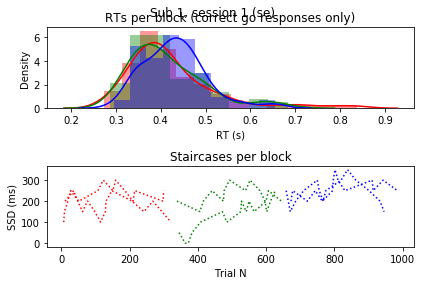

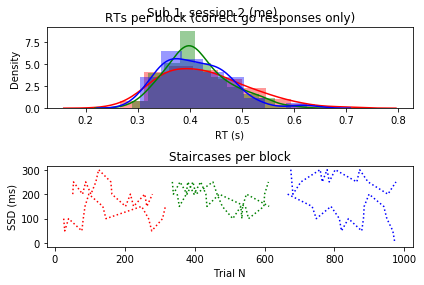

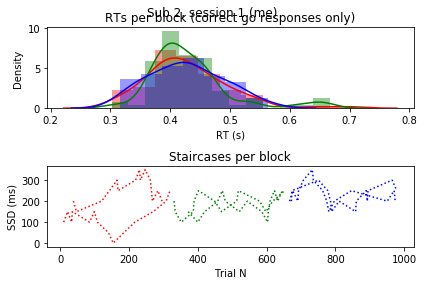

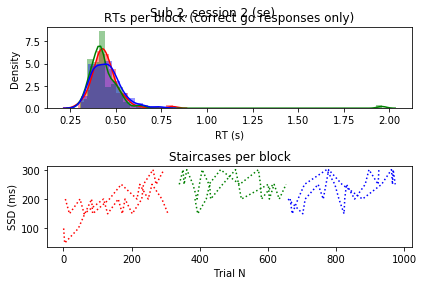

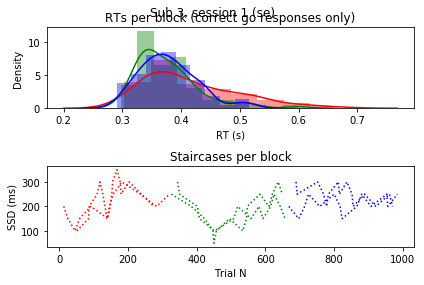

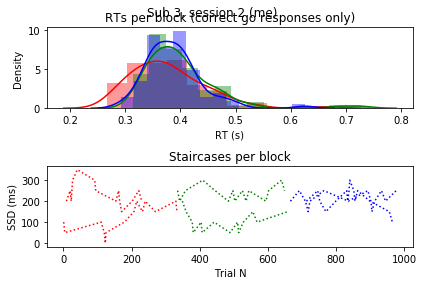

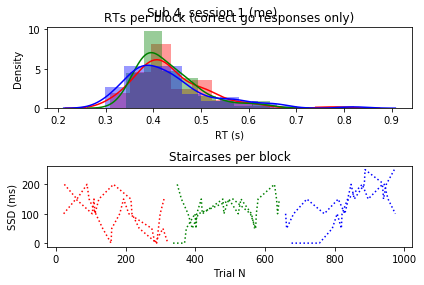

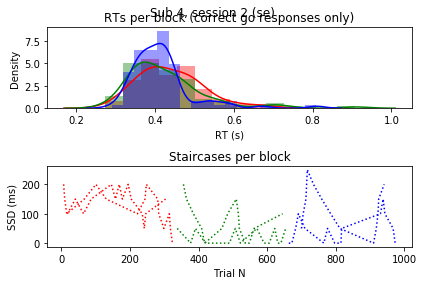

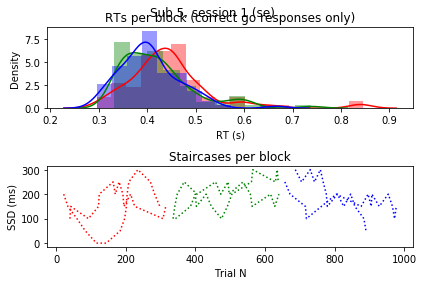

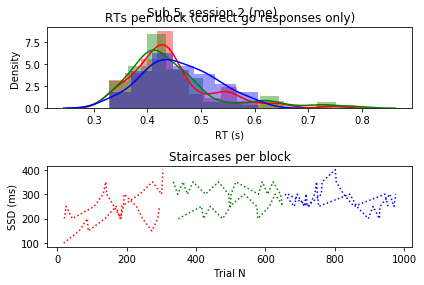

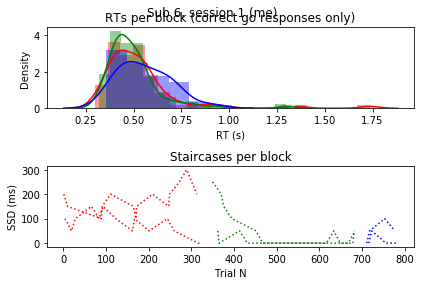

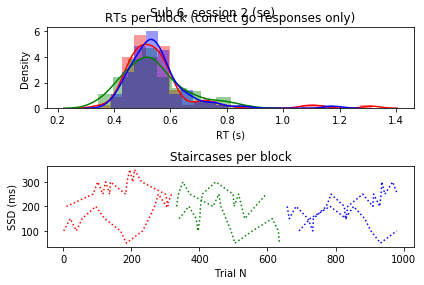

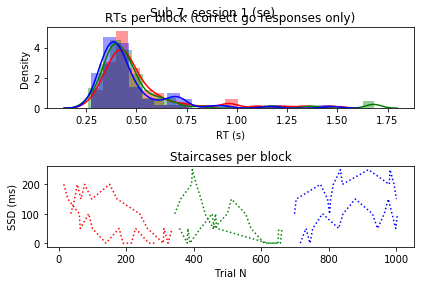

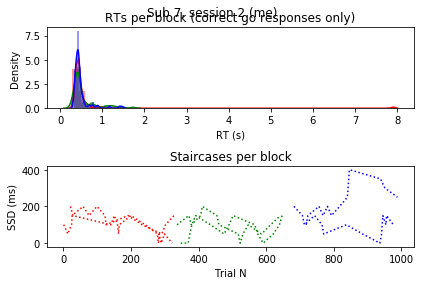

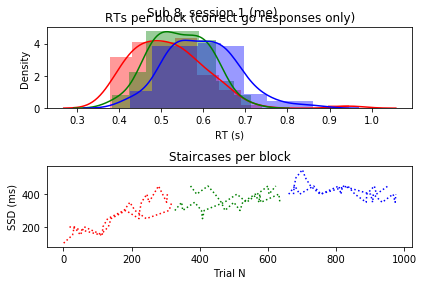

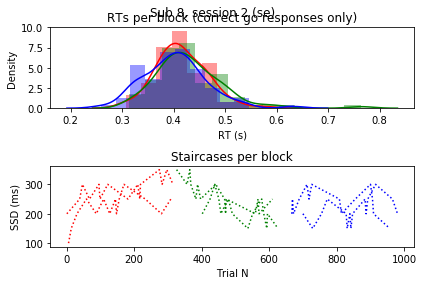

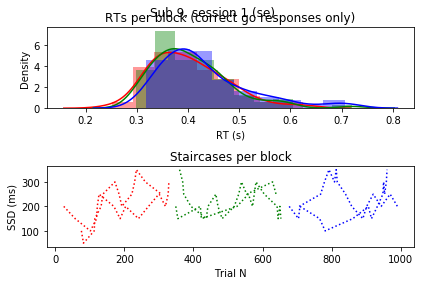

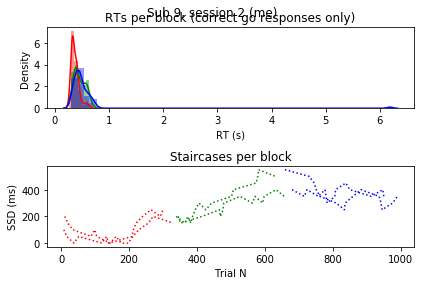

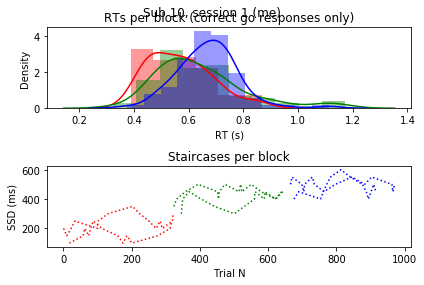

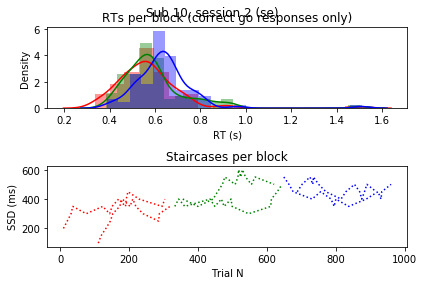

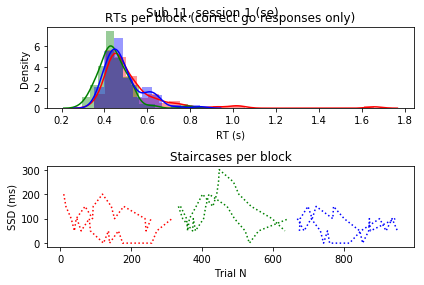

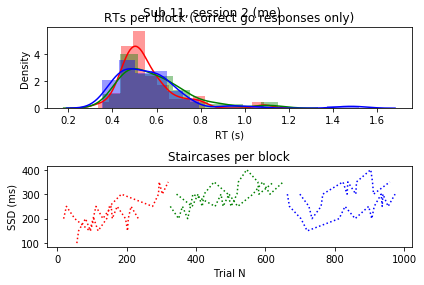

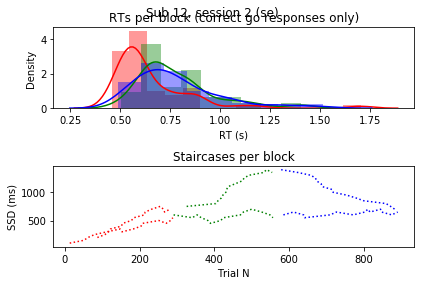

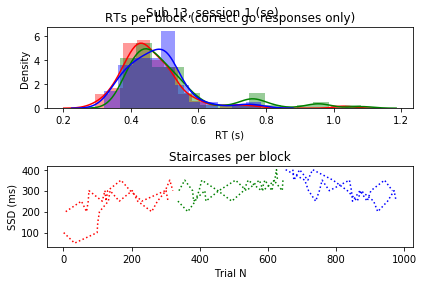

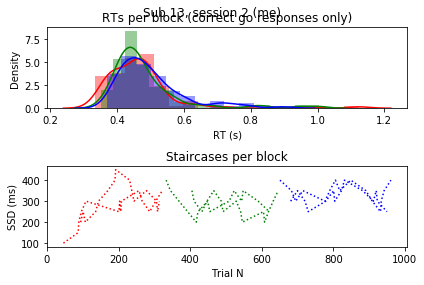

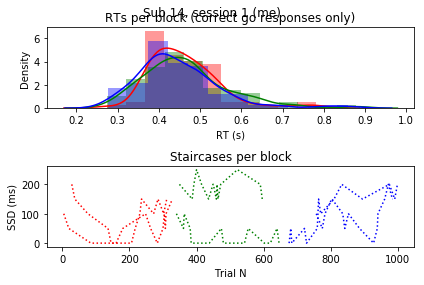

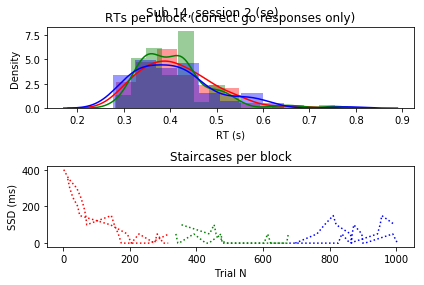

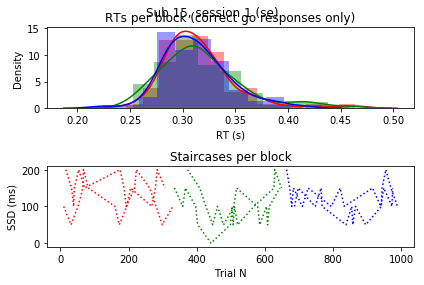

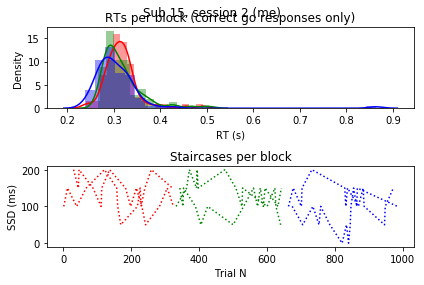

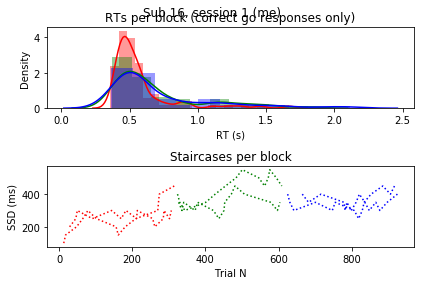

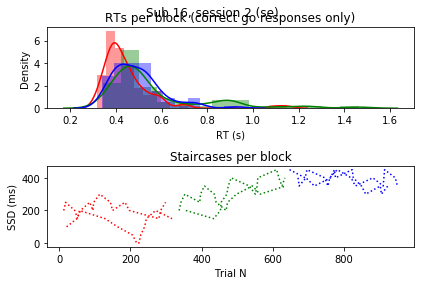

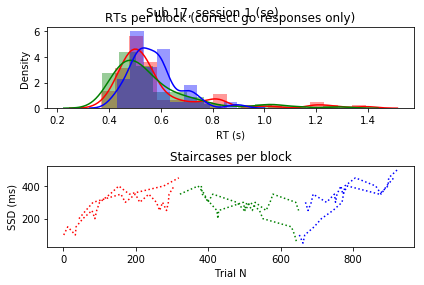

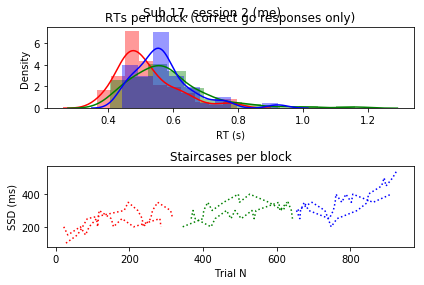

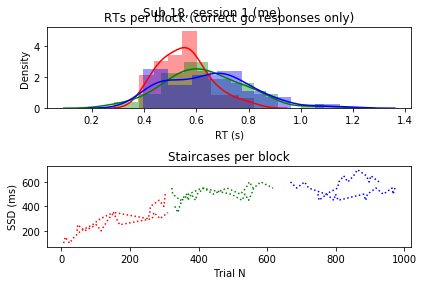

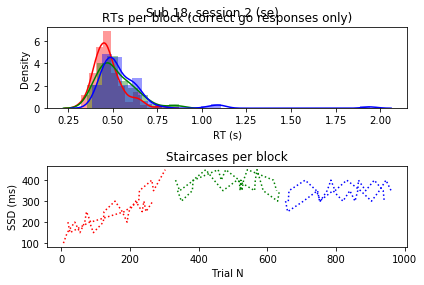

In [6]:
behav_data_dict = {'./data/raw/behavior/S1s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S1s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S2s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S2s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S3s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S3s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S4s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S4s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S5s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S5s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S6s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S6s2-stop_fmri.log': 'se',  ### TO DO: combine log files properly for this pp
                   './data/raw/behavior/S7s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S7s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S8s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S8s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S9s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S9s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S10s1-stop_fmri.log': 'me',
                   './data/raw/behavior/to_combine/S10s2-stop_combined.log': 'se',
#                   './data/raw/behavior/S10s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S11s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S11s2-stop_fmri.log': 'me',
#                    './data/raw/behavior/S12s1-stop_fmri2.log': 'me',  # maybe just remove this one? Useless data anyway
                   './data/raw/behavior/S12s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S13s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S13s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S14s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S14s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S15s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S15s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S16s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S16s2-stop_fmri.log': 'se',
                   './data/raw/behavior/S17s1-stop_fmri.log': 'se',
                   './data/raw/behavior/S17s2-stop_fmri.log': 'me',
                   './data/raw/behavior/S18s1-stop_fmri.log': 'me',
                   './data/raw/behavior/S18s2-stop_fmri.log': 'se'
                  }
print(len(behav_data_dict))
out_dir = './data/deriv/fmriprep/'

for fn, ses in behav_data_dict.items():
    print(fn)
    get_behavioral_descriptives(fn = fn, plot_save_fn=fn.replace('.log', '_behav.png'), 
                                save=False, out_dir=out_dir, log=None, return_long=False, return_wide=True,
                                session_type=ses)

#### Behavioral analyses
Make sure theres no difference in SSRT "performance" between sessions

In [183]:
## Get SSRTs
all_behav = []

for fn, ses in behav_data_dict.items():
#    print(fn)
    this_ses = parse_log_file(fn = fn,
                              save=False, log=None, return_long=False, return_wide=True,
                              session_type=ses)
    this_ses['session_type'] = ses
    all_behav.append(this_ses)
dat = pd.concat(all_behav)

# remove fixation cross as "trial"
dat = dat[dat['trial_type'] != 'fixation_cross']

# remove some columns
dat = dat[['Code', 'Subject', 'Time', 'Trial', 'correct_response', 'event_type', 
           'required_response_direction', 'jitter', 'response_direction',
           'rt', 'run', 'session_type', 'ssd', 'staircase', 'stimulus_direction', 'trial_type']]

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # This is added back by InteractiveShellApp.init_path()


In [184]:
import re
regex = re.compile('.*S(?P<sub>\d+)s(?P<ses>\d+)*')
dat['session_n'] = dat['Subject'].apply(lambda x: regex.match(x)['ses'])
dat['subject'] = dat['Subject'].apply(lambda x: regex.match(x)['sub'])

# remove run 3 of subject 17 (both sessions)
dat = dat.loc[~((dat['subject'] == '17') & (dat['run']==3))]

# remove subject 12
dat = dat.loc[dat.subject != '12']
dat.subject = pd.to_numeric(dat.subject)

# remove RTs > 1s of go trials and RTs < .15s
exclude_for_RT_idx = (((np.in1d(dat['trial_type'], ['go', 'failed_stop'])) & (dat['rt'] > 1)) |
                      ((np.in1d(dat['trial_type'], ['go', 'failed_stop'])) & (dat['rt'] < .15)) |
                      ((np.in1d(dat['trial_type'], ['go', 'failed_stop'])) & (pd.isnull(dat['rt']))))
print('Excluding {:.3f}% of go trials based on RT'.format(exclude_for_RT_idx.sum()/dat.shape[0]))

# How many errors?
error_trial = (np.in1d(dat['trial_type'], ['go', 'failed_stop']) & (dat['correct_response']==False))
print('{:.3f}% of trials were errors'.format(error_trial.sum()/dat.shape[0]))

dat = dat.loc[~exclude_for_RT_idx]

Excluding 0.020% of go trials based on RT
0.015% of trials were errors


In [209]:
def get_descriptives(x):
    mean_go_rt = x.loc[(x.event_type=='go_trial') & (pd.notnull(x.rt)), 'rt'].mean()
    median_go_rt = np.median(x.loc[(x.event_type=='go_trial') & (pd.notnull(x.rt)), 'rt'])
    
    mean_failed_stop_rt = x.loc[x.event_type=='failed_stop', 'rt'].mean()
    median_failed_stop_rt = np.median(x.loc[x.event_type=='failed_stop', 'rt'])
    
    # SSRT
    failed_stop_rate = np.sum(x.event_type=='failed_stop') / np.sum(x.trial_type=='stop')
    # mean SSD
    mean_ssd = x.ssd.mean(skipna=True)/1000  # to s
    # go RT at failed_stop_rate percentile
    go_rt_at_percentile = np.percentile(x.loc[(x.trial_type=='go') & pd.notnull(x.rt) & (x.correct_response==True), 'rt'], failed_stop_rate*100)
    ssrt = go_rt_at_percentile - mean_ssd

    # accuracy
    accuracy = (x.event_type=='go_trial').sum() / ( (x.event_type=='go_trial').sum() + (x.event_type=='go_error').sum() )
    
    failed_stop_rate = np.sum(x.event_type=='failed_stop') / np.sum(x.trial_type=='stop')
    
    misses = np.sum((x.trial_type=='go') & (pd.isnull(x.response_direction))) / np.sum(x.trial_type=='go')
    
    out = pd.Series({'Median go RT': median_go_rt*1000,
                     'Mean go RT': mean_go_rt*1000,
                     'Median failed stop RT': median_failed_stop_rt*1000,
                     'Mean failed stop RT': mean_failed_stop_rt*1000,
                     'SSD': mean_ssd*1000,
                     'SSRT': ssrt*1000,
                     'Go accuracy': accuracy,
                     'Perc. inhibition': failed_stop_rate,
                     'Misses (go)': misses})
    return out
    
aggregated_per_run = dat.groupby(['subject', 'session_type', 'run']).apply(get_descriptives)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(aggregated_per_run)

Median go RT  Mean go RT  Median failed stop RT  \
subject session_type run                                                    
1       me           1          418.70  427.563095                 361.20   
                     2          403.00  414.861446                 375.65   
                     3          405.60  410.096471                 396.30   
        se           1          399.55  422.602381                 390.00   
                     2          393.15  414.471429                 359.20   
                     3          426.70  431.007059                 380.20   
2       me           1          418.55  427.871429                 415.15   
                     2          417.80  431.425882                 381.70   
                     3          424.80  427.020000                 416.30   
        se           1          430.10  439.554118                 381.00   
                     2          415.70  426.351765                 404.10   
                     3          438.85  446.595238                 412.00   
3       me           1          367.20  377.269412                 359.20   
                     2          387.40  400.332941                 359.50   
                     3          379.10  386.721176                 351.50   
        se           1          388.70  415.621176                 354.15   
                     2          363.40  375.887059                 351.00   
                     3          372.00  378.603529                 358.20   
4       me           1          418.10  435.071765                 409.00   
                     2          414.70  431.171429                 420.20   
                     3          412.35  432.838095                 399.20   
        se           1          428.25  437.832143                 412.30   
                     2          404.60  427.259036                 414.00   
                     3          403.10  413.754118                 395.90   
5       me           1          429.30  445.592941                 437.85   
                     2          424.60  448.775000                 377.15   
                     3          447.90  458.252941                 399.50   
        se           1          438.70  447.057143                 390.70   
                     2          405.80  421.177647                 369.10   
                     3          400.20  405.609412                 371.60   
6       me           1          483.80  502.475610                 433.30   
                     2          465.90  487.207407                 439.65   
                     3          542.95  557.146154                 509.05   
        se           1          527.30  530.901250                 480.70   
                     2          528.60  539.476471                 480.60   
                     3          530.60  542.892771                 530.80   
7       me           1          421.40  445.427711                 389.30   
                     2          418.00  452.485714                 416.60   
                     3          422.80  449.535000                 405.10   
        se           1          440.00  474.481818                 371.35   
                     2          421.40  436.762338                 412.10   
                     3          406.00  445.867089                 417.90   
8       me           1          510.10  518.685882                 453.70   
                     2          543.65  544.972093                 468.80   
                     3          596.15  596.941860                 519.75   
        se           1          410.60  415.178824                 399.70   
                     2          423.15  430.229545                 406.45   
                     3          402.50  403.361176                 381.20   
9       me           1          350.70  372.296471                 324.05   
                     2          432.90  459.447059                 385.70   
                     3

In [210]:
aggregated = dat.groupby(['subject', 'session_type']).apply(get_descriptives).reset_index()

# drop 12 for stats
aggregated = aggregated.loc[aggregated['subject'] != '12']
aggregated

,subject,session_type,Median go RT,Mean go RT,Median failed stop RT,Mean failed stop RT,SSD,SSRT,Go accuracy,Perc. inhibition,Misses (go)
0,1,me,407.50,417.488095,379.00,388.817778,177.586207,232.044828,0.992126,0.517241,0.0
1,1,se,406.70,422.726482,374.40,385.960000,208.522727,201.577273,0.992157,0.511364,0.0
2,2,me,420.95,428.775984,413.20,403.941463,201.724138,215.498851,0.996078,0.471264,0.0
3,2,se,425.30,437.464567,398.40,399.470732,222.413793,200.732184,0.996078,0.471264,0.0
4,3,me,379.30,388.107843,358.10,374.245238,187.931034,189.989655,0.992218,0.482759,0.0
5,3,se,377.00,390.037255,355.20,367.433333,212.068966,160.951724,0.992218,0.482759,0.0
6,4,me,415.90,433.035178,405.80,410.413333,112.068966,305.603448,0.996063,0.517241,0.0
7,4,se,411.00,426.228175,412.30,428.855319,87.931034,328.908046,0.988235,0.540230,0.0
8,5,me,434.40,450.881890,391.90,401.387500,270.689655,157.735632,0.996078,0.459770,0.0
9,5,se,411.50,424.526378,378.10,388.055556,178.735632,235.181609,1.000000,0.517241,0.0


In [212]:
display(aggregated.groupby('session_type').mean().round(2))
display(aggregated.groupby('session_type').std().round(2))

,subject,Median go RT,Mean go RT,Median failed stop RT,Mean failed stop RT,SSD,SSRT,Go accuracy,Perc. inhibition,Misses (go)
session_type,,,,,,,,,,
me,9.35,463.42,480.18,431.08,446.3,232.30,229.56,1.00,0.49,0.0
se,9.35,438.82,454.81,412.36,424.7,206.79,233.50,0.99,0.51,0.0


,subject,Median go RT,Mean go RT,Median failed stop RT,Mean failed stop RT,SSD,SSRT,Go accuracy,Perc. inhibition,Misses (go)
session_type,,,,,,,,,,
me,5.47,78.49,79.72,62.19,65.32,108.48,91.54,0.01,0.07,0.0
se,5.47,63.54,66.06,54.90,56.64,94.49,83.54,0.01,0.07,0.0


In [219]:
?stats.ttest_rel

t(16) = 0.289, p = 0.776, p(corrected) = 0.776  (SSRT)
t(16) = -2.258, p = 0.038, p(corrected) = 0.191  (Median go RT)
t(16) = -1.500, p = 0.153, p(corrected) = 0.255  (Go accuracy)
t(16) = -1.505, p = 0.152, p(corrected) = 0.255  (SSD)
t(16) = 1.141, p = 0.271, p(corrected) = 0.339  (Perc. inhibition)
(-0.01492540919304342, 0.9546612609029601)
(-0.06828367614424699, 0.7945558107345427)


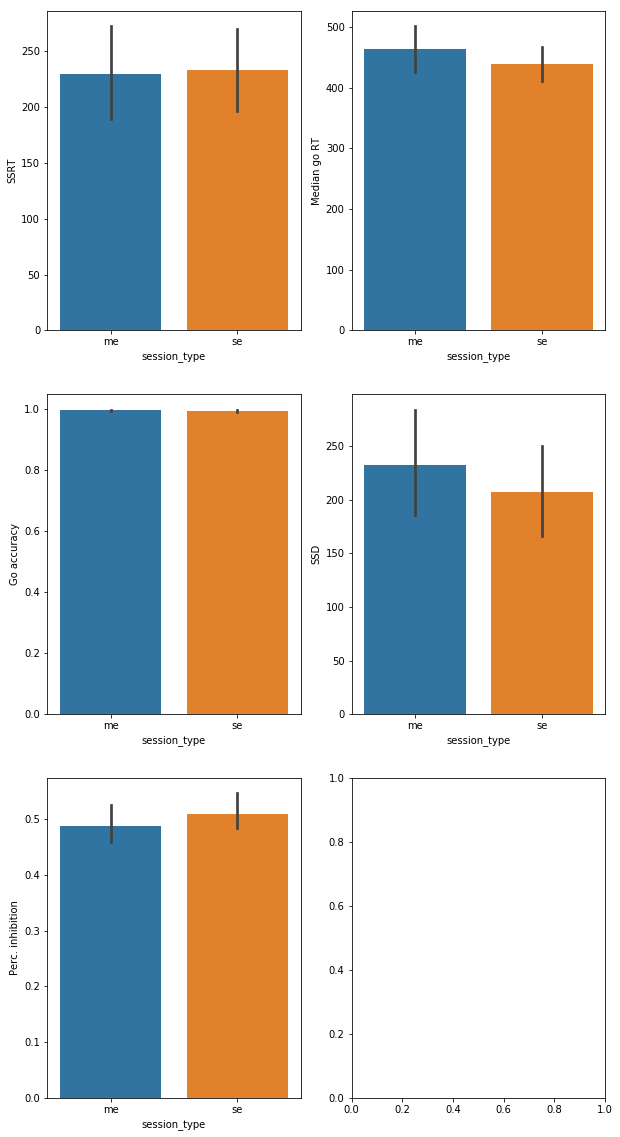

In [222]:
import seaborn as sns
from scipy import stats
import statsmodels as sm
from statsmodels.sandbox.stats import multicomp
f, ax = plt.subplots(3,2)

test_names = ['SSRT', 'Median go RT', 'Median failed stop RT', 'Go accuracy', 'SSD', 'Perc. inhibition']
all_tests = []
for i, colname in enumerate(test_names):
    sns.barplot(x='session_type', y=colname, data=aggregated, ax=ax[int(np.floor(i/2)), int(i%2)])
    all_tests.append(stats.ttest_rel(aggregated.loc[aggregated.session_type=='se', colname], 
                                     aggregated.loc[aggregated.session_type=='me', colname], nan_policy='omit'))
f.set_size_inches(10, 20)



# multiple comparison corrections
p_vals = multicomp.multipletests([x[1] for x in all_tests], method='fdr_bh')[1]
[print('t(16) = %.3f, p = %.3f, p(corrected) = %.3f  (%s)' %(x[0], x[1], y, name)) for name, x,y in zip(test_names, all_tests, p_vals)]

# correlation between median go RTs and SSRTs?
print(stats.pearsonr(aggregated.loc[aggregated.session_type=='se', 'Median go RT'],
                     aggregated.loc[aggregated.session_type=='se', 'SSRT']))

print(stats.pearsonr(aggregated.loc[aggregated.session_type=='me', 'Median go RT'],
                     aggregated.loc[aggregated.session_type=='me', 'SSRT']))

In [217]:
??multicomp.multipletests

Overall, the RTs *look* a little bit lower in the single echo condition. The results are not significant after MC correction, but it may still be worthwhile to think about the meaning of a potential RT difference.

The only obvious difference between SE/ME I can think of were the sound levels of the sequence. The ME was very loud. In combination with the auditory nature, one might wonder whether this interferes with performance.
However, if the *sound levels* were the issue, it is not clear why the *go RTs* would be any slower. In go trials, there is no sound.

One option may be that participant applied a waiting-strategy, to 'see if the tone comes'. However, participants were explicitly not instructed to do this. In terms of data, if participants would apply this strategy (more in ME than in SE), the successfull inhibition rate should be higher in the ME condition (it isn't), and as a result, the SSDs would be much higher (they are a little bit higher but not significantly - even without MC correction and a high alpha). Also, in this case, the SSRT should correlate with the median Go RT - which it doesn't (not even close).

Alternatively, participants just missed the auditory tone in some trials in the ME session. This would cause responding during stop trials, and as a result decrease SSDs. However, SSDs are not significantly lower in the ME session (even without MC corrections), lending little credit to this interpretation..

Most importantly (I would say), the SSRTs between conditions show no signs of any difference.

With a very liberal look at the data, one might say that the participants performed a little bit "better" in the SE session: RTs were lower, percentage inhibition was higher (but not significantly), go accuracy was higher (but not significantly). But even accepting this interpretation, the effect size is minimal, and behavior is *almost* the same.

Maybe there was a time effect? Were people better at the second session?

Ttest_relResult(statistic=1.938004464326274, pvalue=0.070476087872319)

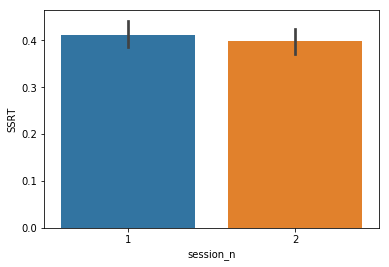

In [29]:
aggregated = dat.groupby(['subject', 'session_n']).apply(get_ssrt).reset_index()#.rename(columns={0: 'SSRT'}, inplace=True)
aggregated = aggregated.rename(columns={0: 'SSRT'})
aggregated = aggregated.loc[aggregated.subject != '12']

sns.barplot(x='session_n', y='SSRT', data=aggregated)
stats.ttest_rel(aggregated.loc[aggregated.session_n=='1', 'SSRT'], aggregated.loc[aggregated.session_n=='2', 'SSRT'])

#### Close but no cigar

### Create EV-files for FEAT

In [12]:
import pandas as pd
import numpy as np
import glob

In [26]:
sub = '01'
ses = 'se'
run = 1
evs = ['go_trial', 'failed_stop', 'successful_stop']

fn = './data/deriv/fmriprep/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-stop_run-{run}_events.tsv'.format(**{'sub':sub, 'ses':ses, 'run':run})
output_dir = './data/feat_files/sub-{sub}/ses-{ses}/evs/'.format(**{'sub':sub, 'ses':ses})
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

events = pd.read_csv(fn, sep='\t')
events['weight'] = 1.

for i, ev in enumerate(evs):
    events.loc[events['trial_type']==ev, ['onset', 'duration', 'weight']].to_csv(output_dir+'{}.txt'.format(ev), sep='\t', index=False, header=False)

### Create EV-files for motion parameters from confounds

In [ ]:
!ls ./data/deriv/fmriprep/sub-01/ses-me/func/sub-01_ses-me_task-stop_run-1_echo-1_desc-confounds_regressors.tsv

In [ ]:
!ls ./data/deriv/fmriprep/sub-01/ses-se/func/sub-01_ses-se_task-stop_run-1_desc-confounds_regressors.tsv

In [37]:
sub = '01'
ses = 'se'
run = 1
evs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'framewise_displacement']

if ses == 'se':
    fn = './data/deriv/fmriprep/sub-{sub}/ses-se/func/sub-{sub}_ses-se_task-stop_run-{run}_desc-confounds_regressors.tsv'.format(**{'sub':sub, 'run':run})
else:
    fn = './data/deriv/fmriprep/sub-{sub}/ses-me/func/sub-{sub}_ses-me_task-stop_run-{run}_echo-1_desc-confounds_regressors.tsv'.format(**{'sub':sub, 'run':run})

events = pd.read_csv(fn, sep='\t')

for i, ev in enumerate(evs):
    events[ev].fillna(0).to_csv(output_dir+'{}.txt'.format(ev), sep='\t', index=False, header=False)

In [36]:
pd.read_csv(output_dir+'framewise_displacement.txt', sep='\t', header=None)

,0
0,NaN
1,0.063687
2,0.024780
3,0.056906
4,0.027549
5,0.028514
6,0.031895
7,0.025771
8,0.039298
9,0.022609


In [27]:

!cat ./data/feat_files/sub-01/ses-se/evs/go_trial.txt


0.7764	1.0171	1.0
11.2805	1.0170000000000001	1.0
46.5274	1.0171	1.0
54.7806	1.0170000000000001	1.0
73.5378	1.0171	1.0
82.5246	1.0171	1.0
102.0321	1.0171	1.0
108.7847	1.0171	1.0
128.2756	1.0171	1.0
137.2791	1.0170000000000001	1.0
144.782	1.0170000000000001	1.0
174.0266	1.0170000000000001	1.0
183.0299	1.0172	1.0
192.0335	1.0171	1.0
210.0404	1.0171	1.0
216.793	1.0171	1.0
225.7798	1.0171	1.0
235.5336	1.0171	1.0
253.5405	1.0171	1.0
262.54400000000004	1.0171	1.0
271.5308	1.0170000000000001	1.0
280.5343	1.0171	1.0
290.2881	1.0170000000000001	1.0
308.295	1.0171	1.0
317.2985	1.0170000000000001	1.0
334.5384	1.0171	1.0
345.0425	1.0171	1.0
362.2991	1.0171	1.0
370.5357	1.0170000000000001	1.0
389.2929	1.0170000000000001	1.0
415.5363	1.0171	1.0
425.2901	1.0171	1.0
434.2936	1.0170000000000001	1.0
443.29699999999997	1.0171	1.0
452.3005	1.0171	1.0
480.0445	1.0171	1.0
488.2977	1.0171	1.0
505.5544	1.0170000000000001	1.0
513.7909	1.0170000000000001	1.0
525.0452	1.0171	1.0
531.7977	1.0172	1.0
540.8013	1.017

In [24]:
!ls ./data/feat_files/sub-01/ses-se/evs/go_trial.txt


ev_0.txt  ev_2.txt	   go_trial.txt
ev_1.txt  failed_stop.txt  successful_stop.txt


In [185]:
# def get_go_rt(x):
#     go_rts = x.loc[(x.event_type=='go_trial') & (pd.notnull(x.rt)), 'rt'].mean()
#     return go_rts

# def get_median_go_rt(x):
#     go_rts = np.median(x.loc[(x.event_type=='go_trial') & (pd.notnull(x.rt)), 'rt'])
#     return go_rts

# def get_failed_stop_rts(x):
#     failed_stop_rts = x.loc[x.event_type=='failed_stop', 'rt'].mean()
#     return failed_stop_rts

# def get_median_failed_stop_rts(x):
#     failed_stop_rts = x.loc[x.event_type=='failed_stop', 'rt'].mean()
#     return failed_stop_rts

# def get_ssrt(x):
#     ### Mean method (deH et al)
#     failed_stop_rate = np.sum(x.event_type=='failed_stop') / np.sum(x.trial_type=='stop')

#     # mean SSD
#     mean_ssd = np.nanmean(x.ssd)/1e3 #to ms
    
#     # go RT at failed_stop_rate percentile
#     go_rt_at_percentile = np.percentile(x.loc[(x.trial_type=='go') & pd.notnull(x.rt) & (x.correct_response==True), 'rt'], failed_stop_rate*100)
#     ssrt = go_rt_at_percentile - mean_ssd
#     return ssrt

# def get_accuracy(x):
#     return (x.event_type=='go_trial').sum() / ( (x.event_type=='go_trial').sum() + (x.event_type=='go_error').sum() )
# #    return x.loc[x.event_type=='go_trial', 'correct_response'].mean()

# def get_ssd(x):
#     return x.ssd.mean(skipna=True)

# def get_perc_inhib(x):
#     failed_stop_rate = np.sum(x.event_type=='failed_stop') / np.sum(x.trial_type=='stop')
#     return failed_stop_rate

# def get_misses(x):

#     misses = np.sum((x.trial_type=='go') & (pd.isnull(x.response_direction))) / np.sum(x.trial_type=='go')
#     return misses

In [186]:
aggregated_per_run = \
    pd.concat([dat.groupby(['subject', 'session_type', 'run']).apply(get_ssrt),
               dat.groupby(['subject', 'session_type', 'run']).apply(get_go_rt),
               dat.groupby(['subject', 'session_type', 'run']).apply(get_failed_stop_rts),
               dat.groupby(['subject', 'session_type', 'run']).apply(get_accuracy),
               dat.groupby(['subject', 'session_type', 'run']).apply(get_ssd),
               dat.groupby(['subject', 'session_type', 'run']).apply(get_perc_inhib),
               dat.groupby(['subject', 'session_type', 'run']).apply(get_median_go_rt),
               dat.groupby(['subject', 'session_type', 'run']).apply(get_misses)], 
             axis=1).rename(columns={0: 'SSRT',
                                     1: 'Go mRT',
                                     2: 'Failed stop mRT',
                                     3: 'Go accuracy',
                                     4: 'SSD',
                                     5: 'Percentage inhibition',
                                     6: 'Median go RT',
                                     7: 'Misses (go trials)'})#.set_index(['subject', 'session_type', 'run'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    from IPython.display import display
    display(aggregated_per_run)

SSRT    Go mRT  Failed stop mRT  Go accuracy  \
subject session_type run                                                     
1       me           1    0.244645  0.427563         0.378454     0.988235   
                     2    0.213697  0.414861         0.384636     0.988095   
                     3    0.242048  0.410096         0.399556     1.000000   
        se           1    0.204607  0.422602         0.388275     0.988235   
                     2    0.210266  0.414471         0.375808     0.988235   
                     3    0.186076  0.431007         0.391894     1.000000   
2       me           1    0.226303  0.427871         0.410143     0.988235   
                     2    0.232190  0.431426         0.397750     1.000000   
                     3    0.188197  0.427020         0.403931     1.000000   
        se           1    0.234076  0.439554         0.389185     1.000000   
                     2    0.172641  0.426352         0.408787     1.000000   
                     3    0.192407  0.446595         0.399008     0.988235   
3       me           1    0.181548  0.377269         0.375200     0.977011   
                     2    0.215534  0.400333         0.385440     1.000000   
                     3    0.168121  0.386721         0.361364     1.000000   
        se           1    0.157297  0.415621         0.370508     1.000000   
                     2    0.179052  0.375887         0.360220     0.977011   
                     3    0.143148  0.378604         0.372187     1.000000   
4       me           1    0.324634  0.435072         0.391644     1.000000   
                     2    0.317245  0.431171         0.407287     0.988235   
                     3    0.269707  0.432838         0.437362     1.000000   
        se           1    0.299700  0.437832         0.439487     0.988235   
                     2    0.396121  0.427259         0.430716     0.988095   
                     3    0.314328  0.413754         0.413869     0.988372   
5       me           1    0.178448  0.445593         0.428317     1.000000   
                     2    0.138879  0.448775         0.375407     0.988235   
                     3    0.164493  0.458253         0.404286     1.000000   
        se           1    0.288683  0.447057         0.398444     1.000000   
                     2    0.189755  0.421178         0.387855     1.000000   
                     3    0.224334  0.405609         0.378944     1.000000   
6       me           1    0.367948  0.502476         0.490781     1.000000   
                     2    0.552550  0.487207         0.472107     0.975904   
                     3    0.590089  0.557146         0.518717     1.000000   
        se           1    0.300483  0.530901         0.480736     0.987654   
                     2    0.345755  0.539476         0.480047     1.000000   
                     3    0.343124  0.542893         0.519829     0.988095   
7       me           1    0.331900  0.445428         0.460518     1.000000   
                     2    0.321145  0.452486         0.459731     0.945946   
                     3    0.250776  0.449535         0.504786     0.975610   
        se           1    0.391031  0.474482         0.410933     0.974684   
                     2    0.366221  0.436762         0.444794     1.000000   
                     3    0.271303  0.445867         0.461100     0.951807   
8       me           1    0.199431  0.518686         0.437480     1.000000   
                     2    0.173338  0.544972         0.457743     1.000000   
                     3    0.170455  0.596942         0.552021     1.000000   
        se           1    0.153676  0.415179         0.407675     1.000000   
                     2    0.191945  0.430230         0.396606     1.000000   
                     3    0.176869  0.403361         0.389671     1.000000   
9       me           1    0.249717  0.372296         0.333607     0.988372   
                     2    0.084948  0.459447        